Can we develop a model that accurately predicts turbidity for one day in the future using historical data?

# STL Decomposition + ARIMA

In [1]:
import pandas as pd

In [7]:
df = pd.read_csv("data.csv", usecols=['Date', 'turbidity'])

df["turbidity"] = pd.to_numeric(df["turbidity"], errors='coerce')

val = df['turbidity'].mean(skipna=True)

df["turbidity"] = df["turbidity"].replace(0, val)
df.fillna(val, inplace=True)

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)


In [8]:
df.isnull().any()

turbidity    False
dtype: bool

In [9]:
df = df.squeeze(axis=0)
display(df)

,turbidity
Date,
2019-01-01,0.442644
2019-01-02,0.401000
2019-01-03,0.374000
2019-01-04,0.361000
2019-01-05,0.351000
...,...
2022-12-27,0.314000
2022-12-28,0.564500
2022-12-29,0.434000


In [10]:
train = df[:1400]
test = df[-61:]
print(train)
print(test)

            turbidity
Date                 
2019-01-01   0.442644
2019-01-02   0.401000
2019-01-03   0.374000
2019-01-04   0.361000
2019-01-05   0.351000
...               ...
2022-10-27   0.717000
2022-10-28   0.787000
2022-10-29   0.613000
2022-10-30   0.442644
2022-10-31   0.685000

[1400 rows x 1 columns]
            turbidity
Date                 
2022-11-01     0.9370
2022-11-02     0.6830
2022-11-03     0.6670
2022-11-04     0.7470
2022-11-05     0.6470
...               ...
2022-12-27     0.3140
2022-12-28     0.5645
2022-12-29     0.4340
2022-12-30     0.3770
2022-12-31     0.3430

[61 rows x 1 columns]


In [11]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.forecasting.stl import STLForecast
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [ ]:
# identify the order of differencing
diff_order = sm.tsa.arma_order_select_ic(train, ic='aic')['aic_min_order'][1]

# identify the order of the AR component
ar_order = sm.tsa.arma_order_select_ic(train.diff(diff_order).dropna(), ic='aic')['aic_min_order'][0]

# identify the order of the MA component
ma_order = sm.tsa.arma_order_select_ic(train.diff(diff_order).dropna(), ic='aic')['aic_min_order'][1]

print(ar_order, diff_order, ma_order)

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: Convergence

3 2 2


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [12]:

train.index.freq = train.index.inferred_freq
stlf = STLForecast(train, ARIMA, model_kwargs=dict(order=(3, 1, 2), trend="t"))
stlf_res = stlf.fit()

forecast = stlf_res.forecast(61)
print(forecast)


2022-11-01    0.683031
2022-11-02    0.695851
2022-11-03    0.741162
2022-11-04    0.776128
2022-11-05    0.660344
                ...   
2022-12-27    0.734429
2022-12-28    0.748065
2022-12-29    0.779017
2022-12-30    0.810435
2022-12-31    0.691587
Freq: D, Length: 61, dtype: float64


/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


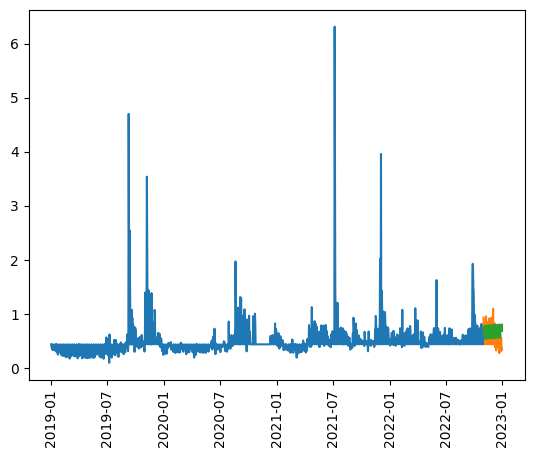

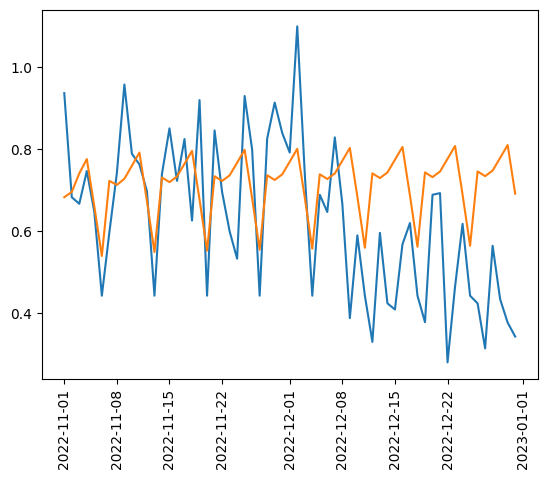

In [13]:
plt.xticks(rotation=90)
plt.plot(train)
plt.plot(test)
plt.plot(forecast)
plt.show()
plt.xticks(rotation=90)
plt.plot(test)
plt.plot(forecast)
plt.show()

In [ ]:
stlf_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    STL Decomposition and SARIMAX Results                     
==============================================================================
Dep. Variable:                      y   No. Observations:                 1400
Model:                 ARIMA(3, 1, 2)   Log Likelihood                 135.862
Date:                Tue, 04 Apr 2023   AIC                           -257.724
Time:                        15:25:38   BIC                           -221.019
Sample:                    01-01-2019   HQIC                          -244.002
                         - 10-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0003      0.001      0.303      0.762      -0.002       0.002
ar.L1          0.1206      0.084      1.431      0.152      -0.045       0.286
ar.L2          0.1953      0.051      3.818      0.000       0.095       0.296
ar.L3          0.2070      0.013     16.271      0.000       0.182       0.232
ma.L1         -0.5392      0.086     -6.248      0.000      -0.708      -0.370
ma.L2         -0.4135      0.081     -5.114      0.000      -0.572      -0.255
sigma2         0.0483      0.000    140.883      0.000       0.048       0.049
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):           1121386.42
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                             7.90
Prob(H) (two-sided):                  0.00   Kurtosis:                       140.80
                                STL Configuration                                
=================================================================================
Period:                             7       Trend Length:                      15
Seasonal:                           7       Trend deg:                          1
Seasonal deg:                       1       Trend jump:                         1
Seasonal jump:                      1       Low pass:                           9
Robust:                         False       Low pass deg:                       1
---------------------------------------------------------------------------------

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
# print(len(test))
def rmse(values, predictions, skip=0):
    import math
    assert(len(values) == len(predictions))
    return math.sqrt(sum([(values[i]-predictions[i])**2 for i in range(skip, len(values))])/len(values))

print(f"RMSE: {rmse(test.iloc[:,0],forecast)}")


RMSE: 0.20493291135140362


# Prophet

In [ ]:
!pip install prophet --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

ds     object
y     float64
dtype: object

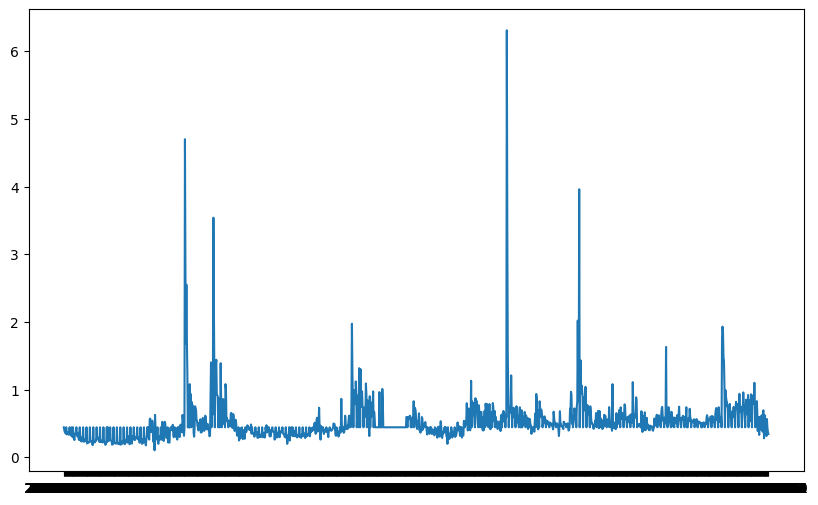

In [ ]:
data = pd.read_csv("data.csv", usecols=['Date', 'turbidity'])
df = data.rename(columns={'Date': 'ds', 'turbidity': 'y'})
#
df["y"] = pd.to_numeric(df["y"], errors='coerce')
val = df['y'].mean(skipna=True)
df["y"] = df["y"].replace(0, val)
df.fillna(val, inplace=True)
df.reset_index()
#
fig = plt.figure(facecolor='w', figsize=(10, 6))
plt.plot(df.ds, df.y)
df.dtypes

In [ ]:
m = Prophet(yearly_seasonality=True)
m.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9d3cwtsp/hoiv9vwo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9d3cwtsp/u_ebmjkf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76165', 'data', 'file=/tmp/tmp9d3cwtsp/hoiv9vwo.json', 'init=/tmp/tmp9d3cwtsp/u_ebmjkf.json', 'output', 'file=/tmp/tmp9d3cwtsp/prophet_model5sbtlbwl/prophet_model-20230405163354.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:33:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:33:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
1821,2023-12-27
1822,2023-12-28
1823,2023-12-29
1824,2023-12-30
1825,2023-12-31


In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1821,2023-12-27,0.477052,0.074871,0.848909
1822,2023-12-28,0.458544,0.066708,0.886925
1823,2023-12-29,0.442304,0.058429,0.839108
1824,2023-12-30,0.433104,0.066968,0.830511
1825,2023-12-31,0.349891,-0.026515,0.734522


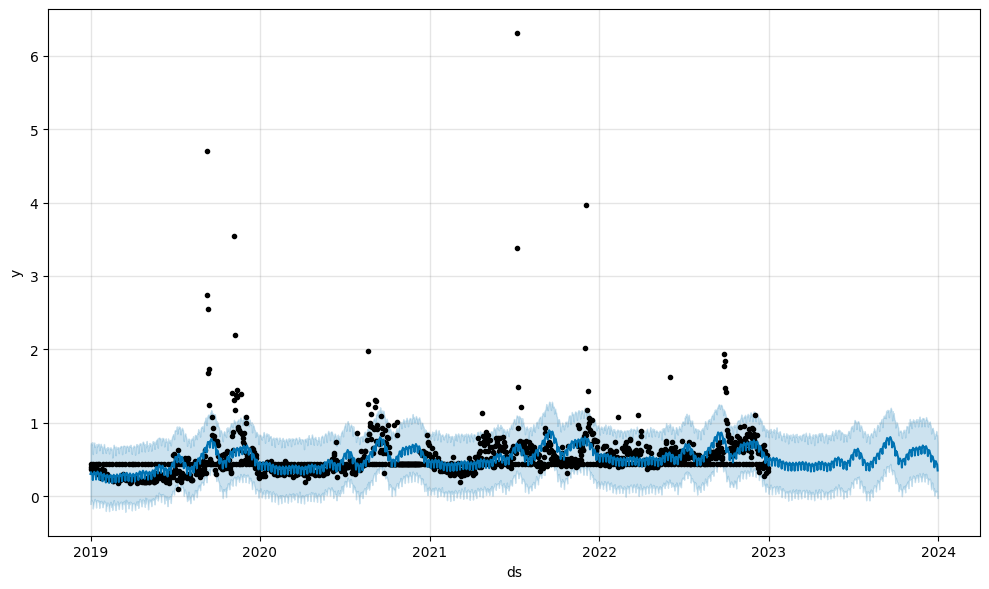

In [ ]:
fig1 = m.plot(forecast)